In [19]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
import seaborn as sns 
from utils import load_ncbi_genome_metadata
import src.download as download
import src.tools as tools
from src import get_genome_id
import glob
from tqdm import tqdm
from src.reference import compare

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset_df = pd.read_csv('../data/dataset/dataset.csv', index_col=0)
# This is the genome metadata for all NCBI reference genomes. 
ncbi_genome_metadata_df = load_ncbi_genome_metadata(genome_metadata_path='../data/dataset/ncbi_genome_metadata.tsv', taxonomy_metadata_path='../data/dataset/ncbi_taxonomy_metadata.tsv') 

In [106]:
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')
test_results_df = test_results_df.merge(pd.read_csv('../data/dataset/dataset_test.csv', index_col=0), left_index=True, right_index=True, how='left')

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
train_results_df = train_results_df.merge(pd.read_csv('../data/dataset/dataset_train.csv', index_col=0), left_index=True, right_index=True, how='left')

results_df = pd.concat([train_results_df, test_results_df])
results_df['length'] = results_df.seq.apply(len)

In [3]:
phyla_in_dataset = np.unique([lineage.split(';')[1] for lineage in dataset_df.lineage[dataset_df.lineage.str.contains(';')]])
# phyla_in_dataset = np.unique([phylum.replace('Candidatus ', '') for phylum in phyla_in_dataset]) 
phyla_in_dataset = np.unique([phylum for phylum in phyla_in_dataset if (phylum != 'environmental samples')])

print(len(phyla_in_dataset), 'phyla in the dataset.')
print(ncbi_genome_metadata_df.phylum.nunique(), 'phyla with NCBI reference genomes.')

83 phyla in the dataset.
56 phyla with NCBI reference genomes.


In [4]:
rare_taxa_df = ncbi_genome_metadata_df[~ncbi_genome_metadata_df.phylum.isin(phyla_in_dataset)].copy()
rare_taxa_df = rare_taxa_df.sort_values('checkm_completeness', ascending=False)
rare_taxa_df = rare_taxa_df.drop_duplicates('phylum', keep='first')

In [ ]:
ncbi = download.ncbi.NCBI()
ncbi.get_genomes(rare_taxa_df.index, include=['gbff', 'genome'], dirs={'genome':'../data/ncbi/genomes', 'gbff':'../data/ncbi/gbffs'})
ncbi.cleanup()

NCBI.get_genomes: Downloading data for GCF_021057185.1.: 100%|██████████| 20/20 [03:05<00:00,  9.29s/it]


In [ ]:
prodigal = tools.Prodigal()
for input_path in tqdm(glob.glob('../data/ncbi/genomes/*'), desc='Running Prodigal on genomes for rare taxa.'):
    output_path = f'../data/prodigal/{get_genome_id(input_path)}.faa'
    if not os.path.exists(output_path):
        prodigal.run(input_path, output_path=output_path)

# Prodigal sometimes predicts a string of X amino acids (unknown), which coincide with assembly gaps. The
# matching proteins are generally marked as partial in the NCBI reference

Running Prodigal on genomes for rare taxa.:   0%|          | 0/20 [00:00<?, ?it/s]

Running Prodigal on genomes for rare taxa.: 100%|██████████| 20/20 [01:58<00:00,  5.94s/it]


In [107]:
if not os.path.exists('../data/results/rare_taxa.csv'):
    compare_df = list()
    for query_path in tqdm(glob.glob('../data/prodigal/*'), desc='Comparing Prodigal predictions with NCBI reference annotations.'):
        reference_path = f'../data/ncbi/gbffs/{get_genome_id(query_path)}_genomic.gbff'
        compare_df += [compare(query_path, reference_path)]
    compare_df = pd.concat(compare_df)

    rare_taxa_df = compare_df.merge(rare_taxa_df, left_on='genome_id', right_index=True)
    rare_taxa_df = rare_taxa_df.rename(columns={'query_seq':'seq'})
    rare_taxa_df.to_csv('../data/results/rare_taxa_.csv') # Save all sequences, inncluding those exceeding the maximum length. 

    mask = rare_taxa_df.seq.apply(len) < 2000
    print((~mask).sum(), 'Prodigal-predicted sequences exceed the maximum length.')
    rare_taxa_df = rare_taxa_df[mask].copy()
    rare_taxa_df.to_csv('../data/results/rare_taxa.csv')
else:
    rare_taxa_df = pd.read_csv('../data/results/rare_taxa.csv', index_col=0)


GCF_029854295.1
GCF_021057185.1


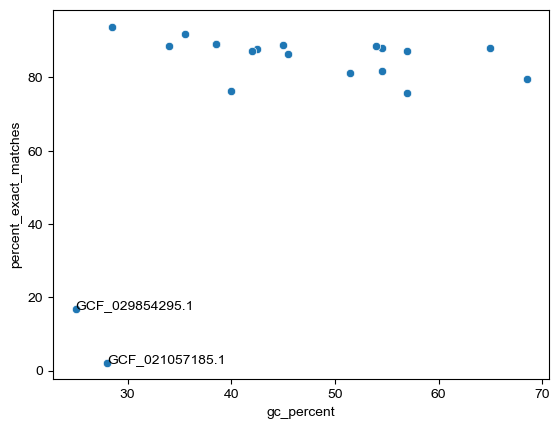

In [110]:
ax_df = pd.DataFrame(index=rare_taxa_df.genome_id.unique())
ax_df['gc_percent'] = rare_taxa_df.groupby('genome_id').gc_percent.first()
# ax_df['genome_size'] = rare_taxa_df.groupby('genome_id').apply(len, include_groups=False)
ax_df['genome_size'] = rare_taxa_df.groupby('genome_id').n_gene_protein_coding.first()
ax_df['n_exact_matches'] = rare_taxa_df.groupby('genome_id').exact_match.sum()
ax_df['n_matches'] = rare_taxa_df.groupby('genome_id').match.sum()
ax_df['percent_matches'] = 100 * ax_df.n_matches / ax_df.genome_size
ax_df['percent_exact_matches'] = 100 * ax_df.n_exact_matches / ax_df.genome_size

fig, ax = plt.subplots()


# sns.scatterplot(data=ax_df, x='gc_percent', y='percent_exact_matches')
sns.scatterplot(data=ax_df, x='gc_percent', y='percent_exact_matches')

for row in ax_df.itertuples():
    if row.percent_exact_matches < 20:
        print(row.Index)
        ax.text(row.gc_percent, row.percent_exact_matches, row.Index)


In [6]:
# def figure(dataset_df:pd.DataFrame, level:str='genus', top_n:int=5):

#     fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

#     for ax, (_, df) in zip(axes, dataset_df.groupby('label')):
#         ax_df = df.value_counts(level)
#         ax_df = ax_df / ax_df.sum() * 100
#         ax_df = ax_df[ax_df.index != 'none'].copy()
#         ax_df = ax_df.iloc[:top_n]

#         sns.barplot(data=ax_df, ax=ax, color='lightgray', edgecolor='black')

#         if (level == 'species'):
#             x_tick_labels = [f'{taxon.split()[0][0]}. {taxon.split()[-1]}' for taxon in ax_df.index]
#             ax.set_xticks(np.arange(len(ax_df)), labels=x_tick_labels, rotation=90, fontstyle='italic')
#         else:
#             ax.set_xticks(np.arange(len(ax_df)), labels=ax_df.index, rotation=90)
#         ax.yaxis.set_major_formatter(tick.PercentFormatter())
#         ax.text(0.5, 0.7, f'{ax_df.sum():.2f}% in top {top_n} {level}', transform=ax.transAxes)

#     axes[0].set_title('AntiFam')
#     axes[1].set_title('SwissProt')

#     fig.tight_layout()
#     plt.show()

# figure(dataset_df, level='phylum')